# OpenCV for MathVision

Installing opencv2, numpy, matplotlib, and sys.

In [181]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import math

Reading and displaying the starter image. Image resizing is temporary and only for displaying purposes.

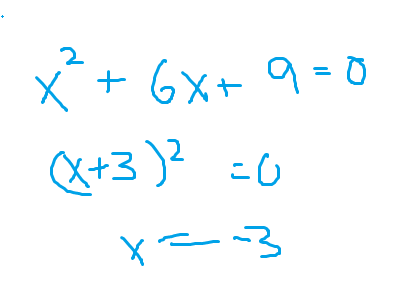

In [182]:
image = cv2.imread('/content/download.png')
cv2_imshow(image)



In [183]:
print(image.shape)

(308, 394, 3)


# TLDR
In order to calculate and crop the bounding boxes of the images, we first need apply a threshhold to an image. This essentially means that we are "binarizing the image". Here, any pixel color value lower than the threshold is set as 0, and any other is set as 1.

With the cv2.threshold(image, thresh-val, max-val, thresholding types) function this is achieved. Here is the breakdown our code:

1.   Image is converted to grayscale
2.   We apply a binary threshold and otsu threshold to the image
3.   We apply a dilation on the threshold image
4.   We create an inversion of the threshold image

## Full Breakdown

Upon converting the image to grayscale we apply a binary threshold and otsu threshold to the image. For the purposes of this portion of the project we need the binary conversion to be very strict, and with otsu binarization this is achieved.

![otsu.jpg](https://docs.opencv.org/3.4/otsu.jpg)

**What is otsu's binarization?**
In our original thresholding methods, we input a general threshold, and then use an arbitrary value as a threshold. With otsu's binarization, we **optimize that**, where instead of us choosing the threshold, otsu does it for us. The way this works is by choosing a threshold value for an image which only has two histogram peaks (see example image). The example also shows how using gaussian filtering optimizes the otsu work.

Note: When using the otsu binarization the passed in threshold values are arbitrary.

**Dilation**
Following these changes, we use dilation which is a basic morplogical operator used for "growing" the image.

We also create an inverted mask if the image, which is used in later parts.

In [184]:
def prepare_image(image, dimension_size):
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_th = cv2.GaussianBlur(img_gray, (5,5),0)

  ret,thresh1=cv2.threshold(img_th,0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
  rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, dimension_size)
  # Applying dilation on the threshold image
  dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)


  inverted_image = cv2.bitwise_not(img_th)
  ret1,thresh2=cv2.threshold(inverted_image,0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
  inverted_dilation = cv2.dilate(thresh2, rect_kernel, iterations = 1)

  return (dilation, inverted_dilation)

# Getting Contour Data
When we call for the contour and contour inverse data, we get an array of arrays containing x,y coordinates of contour points.

However, when .findContours is used, it detects only the darker color on a lighter foreground. If for example, the image was written in white writing on a black background, the contours data would be very small. Due to this, we compare the length of the contours data. Whichever has an array with more data points will be the contour data with actual information.

In [185]:
def get_contours(dilation, inverted_dilation):
  # Finding contours
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  # Finding contours inverse
  contours_mask, hierarchy = cv2.findContours(inverted_dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  if len(contours) > len(contours_mask):
    cntrs = contours
  else:
    cntrs = contours_mask

  return cntrs

# Bordered Images & Cropping

One problem we faced while writing this script was that images with a background to the main color would only get cropped once. For example, if you took a photo of text on a white sheet of paper, but the sheet of paper had a black background behind it, the contours would only return the borders of the white sheet.

To deal with this we wrote a while loop, which would run as long as the length of the contours array is <= 1, and a counter variable is less than 16 (to make sure that in case the image is alternating, we won't throw an error).

In this loop we use keep track of the max and minimum x values, and crop the sheet at these points. Then we find the contours again, and increment the counter. If after this we still see the contours to be <=1, we crop again.

In [186]:
def prepare_crop(image):
  dilation, inverted_dilation = prepare_image(image, (1,1))
  cntrs = get_contours(dilation, inverted_dilation)
  return border_fix(image, dilation, inverted_dilation)


In [187]:
def border_fix(image, dilation, inverted_mask):

  # Initializing temporary variables to be used
  final_contours = None
  counter = 0
  cropped_image = image.copy()


  # Finding contours
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  # Finding contours inverse
  contours_mask, hierarchy = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)

  contour_len = len(contours)
  contour_mask_len = len(contours_mask)
  # Determines the maximum contour length of both
  final_contours_length = max(contour_len, contour_mask_len)

  ''' If the contour length is greater than 1 for both not inverted and inverted,
  then we assume that one of the masks does not include any borders. The problem
  before is that the contours would be found, but it would just end up finding the
  contours of a border
  '''
  while final_contours_length <= 1 and counter<16:

    if (contour_len and contour_mask_len) <=1:

      x1,y1,w1,h1 = cv2.boundingRect(contours[0])
      x2,y2,w2,h2 = cv2.boundingRect(contours_mask[0])

      if w1 * h1 <= w2 * h2:
        src = np.array([[x1,y1],[x1, y1 + h1],[x1 + w1, y1 + h1],[x1 + w1, y1]], np.float32)
        dst = np.array([[0,0],[0,h1],[w1, h1],[w1, 0]], np.float32)

        # Getting the linear transformation to be used to warp the image
        MT = cv2.getPerspectiveTransform(src, dst)

        # Remove any rotations, warping issues with the image
        cropped_image = cv2.warpPerspective(cropped_image, MT, (w1, h1))
        dilation = cv2.warpPerspective(dilation, MT, (w1, h1))
        inverted_mask = cv2.warpPerspective(inverted_mask, MT, (w1, h1))

        final_contours = contours
      else:
        src = np.array([[x2,y2],[x2, y2 + h2],[x2 + w2, y2 + h2],[x2 + w2, y2]], np.float32)
        dst = np.array([[0,0],[0,h2],[w1, h2],[w2, 0]], np.float32)
        # Getting the linear transformation to be used to warp the image
        MT = cv2.getPerspectiveTransform(src, dst)

        # Remove any rotations, warping issues with the image
        cropped_image = cv2.warpPerspective(cropped_image, MT, (w2, h2))
        dilation = cv2.warpPerspective(dilation, MT, (w2, h2))
        inverted_mask = cv2.warpPerspective(inverted_mask, MT, (w2, h2))

        final_contours = contours_mask

    counter+=1

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_NONE)
    # Finding contours inverse
    contours_mask, hierarchy = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_NONE)
    contour_len = len(contours)
    contour_mask_len = len(contours_mask)

    final_contours_length = max(contour_len,contour_mask_len)

  return cropped_image

The following loop draws the green rectangles for each coordinate in contours.

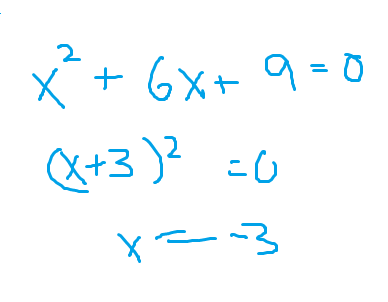

In [188]:
cropped_image = prepare_crop(image)

# Cropping the borders by 1% if case any there was unclean cropping of image
height_diff = int(cropped_image.shape[0] * 0.01)
width_diff = int(cropped_image.shape[1] * 0.01)

cropped_image = cropped_image[height_diff:cropped_image.shape[0] - height_diff,
                              width_diff:cropped_image.shape[1] - width_diff]

cv2_imshow(cropped_image)


In [189]:
dilation, inverted_dilation = prepare_image(cropped_image, (100,5))


im2 = cropped_image.copy()
cntrs = get_contours(dilation, inverted_dilation)
# draw_crop(cntrs, cropped_image)
# cropped_image = draw_crop(cntrs, cropped_image)
# cv2_imshow(cropped_image)

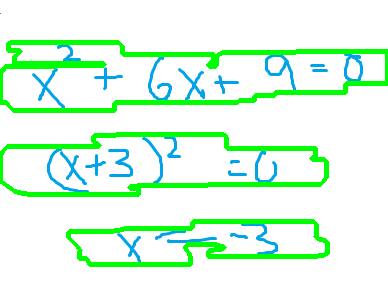

In [190]:
cv2.drawContours(im2, cntrs, -1, (0,255,0),3)
cv2_imshow(im2)

# Extracting Contours

To extract the contours, we want to be able to extract them as a rectangle, but at the same time we only want to keep the information within the green contours shown above.

To do so, we will utilise a mask that will fill the rest of the image besides the contour region of interest (ROI) with black, and the ROI with white. Then we will crop the image and save it to some variables.

In [191]:
def common_color(img):
  unq, count = np.unique(img.reshape(-1,3), axis = 0, return_counts = True)
  common_color = [0,0,0]
  common_color[0], common_color[1], common_color[2]  = unq[np.argmax(count)]

  return common_color


In [192]:
def add_background(img, b_color, cntrs):
  mask_image = img.copy()
  mask_value = 255
  b_mask = np.zeros(img.shape[:-1]).astype(np.uint8)
  # cv2.fillPoly(b_mask, cntrs, mask_value)
  cv2.drawContours(b_mask, [cntrs], -1, (255,255,255), thickness=-1)

  # cv2_imshow(b_mask)

  selection = b_mask != mask_value
  mask_image[selection] = b_color

  cv2.drawContours(mask_image, cntrs, -1, (int(b_color[0]), int(b_color[1]), int(b_color[2])), 1)
  #cv2_imshow(mask_image)

  return mask_image

In [193]:
def extract_contours(img, cntrs, common_color):
  channels = None;
  if (len(img) < 2):
    channels = img.shape[2]
  else:
    channels = 1
  arr = []
  bounding_box = []

  for cntr in cntrs:
    #mask = np.zeros(img.shape, dtype=np.uint8)
    mask = np.full((img.shape[0], img.shape[1], 3), (0, 0, 0), dtype=np.uint8)
    ignore_mask = (255, ) * channels
    cv2.drawContours(mask, [cntr], -1, (255,255,255), thickness=-1)

    mask_image = cv2.bitwise_and(img, mask)
    x, y, w, h = cv2.boundingRect(cntr)
    box = (x,y,w,h)

    bounding_box.append(box)
    #mask_image = cv2.copyMakeBorder(mask_image, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0,0,0])

    filled_image = add_background(mask_image, common_color, cntr)

    # Crop the image
    cropped_line = filled_image[y:y+h,x:x+w]

    #cv2_imshow(cropped_line)
    arr.append(cropped_line)
  return (arr, bounding_box)


In [194]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
b_color = common_color(cropped_image)

(cropped_lines, bounding_box) = extract_contours(cropped_image, cntrs, b_color)

In [195]:
boxcoords = pd.DataFrame([], )
label = ['x', 'y', 'x1', 'y1', 'image']

for i in range(len(bounding_box)):
  boxcoords = pd.concat( [boxcoords, pd.DataFrame([bounding_box[i][0], bounding_box[i][1], bounding_box[i][0] + bounding_box[i][2], bounding_box[i][1]+ bounding_box[i][3], cropped_lines[i]])], axis='columns')


boxcoords = boxcoords.transpose()
boxcoords.columns=label
boxcoords = boxcoords.reset_index()

# boxcoords = boxcoords.sort_values('y1')
boxcoords

,index,x,y,x1,y1,image
0,0,68,221,328,265,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,0,134,327,195,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,0,0,42,388,111,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [196]:
boxcoords = boxcoords.sort_values('y1', ascending=[True])
boxcoords

,index,x,y,x1,y1,image
2,0,0,42,388,111,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,0,134,327,195,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
0,0,68,221,328,265,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [197]:
def identify_letter_helper(single_bounding_box, x1, y1, resize, iter):
  return_box = []
  for i in range(len(single_bounding_box)):
    bound_box = (x1 + single_bounding_box[i][0]/pow(resize, iter),
                 y1 + single_bounding_box[i][1]/pow(resize, iter),
                 x1 + single_bounding_box[i][0]/pow(resize, iter) + single_bounding_box[i][2]/pow(resize, iter),
                 y1 + single_bounding_box[i][1]/pow(resize, iter) + single_bounding_box[i][3]/pow(resize, iter))
    return_box.append(bound_box)
  return return_box

In [202]:
def identify_letter(image, line_images, single_bounding_box, x1, y1, iter):
  resize = 3
  if not hasattr(image,'shape'):
    return
  # To enhance the image
  image = cv2.resize(image, (image.shape[1] * resize, image.shape[0] * resize), interpolation = cv2.INTER_AREA)

  # Creating the sharpening kernel
  kernel = np.array([[-1,-1,-1],
                      [-1, 9,-1],
                      [-1,-1,-1]])

  # Applying the sharpening kernel
  sharpened = cv2.filter2D(image, -1, kernel)

  (dilation, inverted_dilation) = prepare_image(sharpened, (1,100))
  cntrs_line, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                   cv2.CHAIN_APPROX_NONE)
  sharpened_copy = image.copy()

  if len(cntrs_line) == 1:
    # Base case
    return_image = []
    return_box = []
    x, y, w, h = cv2.boundingRect(cntrs_line[0])
    box = (x1 + x/pow(resize, iter),y1 + y/pow(resize, iter), x1 + x/pow(resize, iter)+w/pow(resize, iter),y1 + y/pow(resize, iter)+h/pow(resize, iter))
    return_image.append(sharpened_copy)
    return_box.append(box)

    return (return_image, return_box)
  else:
    # Extract contours gets the width
    (arr, single_bound_box) = extract_contours(sharpened_copy, cntrs_line, b_color)
    # Need to base the contour coordinates based on x1, x2, y1, y2 values.
    single_bound_box = identify_letter_helper(single_bound_box, x1, y1, resize, iter)
    for i in range(len(arr)):
      cv2_imshow(arr[i])
      (tmp_line_images, tmp_box) = identify_letter(arr[i], line_images, single_bound_box,
                                                   single_bound_box[i][0],
                                                   single_bound_box[i][1], iter+1)
      #print(len(tmp_line_images))
      if(len(tmp_line_images) > 1):
        line_images = tmp_line_images
        single_bounding_box = tmp_box
      else:
        line_images = line_images + tmp_line_images
        single_bounding_box = single_bounding_box + tmp_box

  # print(len(line_images))
  return (line_images, single_bounding_box)


## Identifying Individual Letters

To do:
- Sort the line images by either start, median or end x value
- Resize the image to 45x45 while preserving as much quality as possible
- Image processing: Making sure by the time lines are being detected that the background is white in a black/white image.
- Cleaning up the presentation of the code
- Impelement specific image reading (such as for fractions, integrals, square roots, limits) using techniques involving median x value, width, height, median height.

- For identify letter, we need to keep track of the start x and end x for each and insert that instead.

In [199]:
'''
resize takes in an image img and shrinks it to a square and preserves the
aspect ratio by filling the rest of the image with background_colour
'''
def resize(img, width, height, background_colour):
  new_img = None
  # max_size denotes the shape of the square image, which would be max_size x max_size
  max_size = max(img.shape[0], img.shape[1])
  if max_size == img.shape[0]:
    # Might have to have it so that we determine whether we add one pixel or not
    to_add = int((max_size - img.shape[1])/2)
    # top bottom
    new_img = cv2.copyMakeBorder(img, 0, 0, to_add, to_add, borderType=cv2.BORDER_CONSTANT,
                                 value=(int(background_colour[0]), int(background_colour[1]), int(background_colour[2])))
  else:
    to_add = int((max_size - img.shape[0])/2)
    # right left
    new_img = cv2.copyMakeBorder(img, to_add, to_add, 0, 0,  borderType=cv2.BORDER_CONSTANT,
                                 value=(int(background_colour[0]), int(background_colour[1]), int(background_colour[2])))
  resized = cv2.resize(new_img, (width, height), interpolation=cv2.INTER_AREA)
  #cv2_imshow(resized)
  return resized


(69, 388, 3)


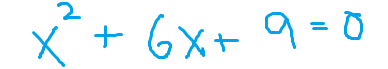

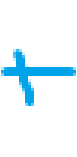

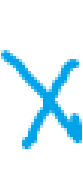

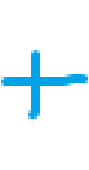

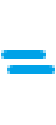

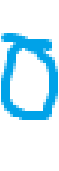

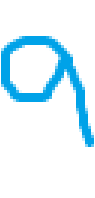

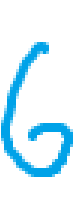

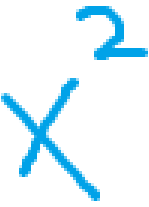

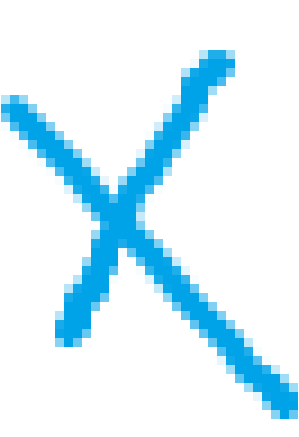

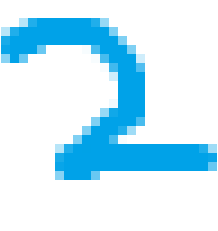

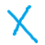

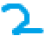

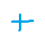

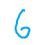

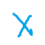

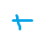

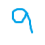

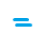

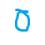

,index,x,y,x1,y1,image
7,0,31.666667,0.0,113.0,69.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
8,0,31.962963,24.148148,97.0,93.037037,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,0,93.666667,8.333333,217.0,73.333333,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
6,0,147.666667,0.0,320.0,69.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,177.666667,9.333333,383.0,78.333333,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
0,0,213.666667,16.666667,453.0,85.666667,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
5,0,264.666667,0.0,561.0,66.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,0,309.666667,5.333333,638.0,52.333333,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,0,343.666667,0.0,707.0,57.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


(61, 327, 3)


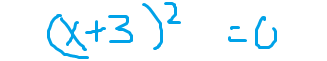

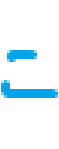

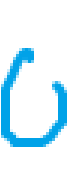

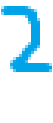

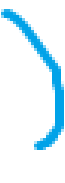

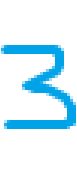

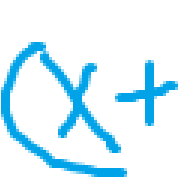

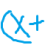

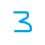

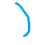

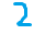

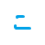

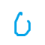

,index,x,y,x1,y1,image
5,0,46.888889,8.444444,153.0,69.444444,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,0,107.888889,9.444444,241.0,58.111111,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,0,141.888889,0.0,305.0,55.666667,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,0,163.888889,0.0,345.0,29.666667,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
0,0,227.888889,20.444444,475.0,68.111111,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,254.888889,10.444444,532.0,65.111111,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


(44, 260, 3)


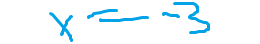

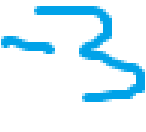

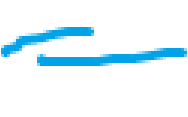

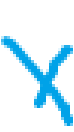

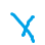

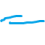

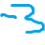

,index,x,y,x1,y1,image
2,0,48.888889,6.444444,122.0,50.444444,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,0,86.888889,3.444444,236.0,31.111111,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
0,0,161.888889,0.0,372.0,39.666667,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [203]:
for i in range(len(boxcoords.index)):
  print(boxcoords['image'].iloc[i].shape)
  cv2_imshow(boxcoords['image'].iloc[i])
  line_images = []
  single_bounding_box = []
  #single_bounding_box not working correctly
  (line_images, single_bounding_box) = identify_letter(boxcoords['image'].iloc[i], line_images, single_bounding_box, 0, 0, 1)

  line_coords = pd.DataFrame([], )
  #print(f'{len(single_bounding_box)} + {len(line_images)}')
  line_label = ['x', 'y', 'x1', 'y1', 'image']
  for i in range(len(line_images)):
    resized_img = resize(line_images[i], 45, 45, b_color)
    line_coords = pd.concat( [line_coords, pd.DataFrame([single_bounding_box[i][0], single_bounding_box[i][1], single_bounding_box[i][0] + single_bounding_box[i][2], single_bounding_box[i][1]+ single_bounding_box[i][3], resized_img])], axis='columns')
    #cv2_imshow(line_images[i])
  line_coords = line_coords.transpose()
  #print(len(line_coords.columns))
  line_coords.columns=line_label
  line_coords = line_coords.reset_index()

  line_coords = line_coords.sort_values('x', ascending=[True])

  for i in range(len(line_coords)):
    cv2_imshow(line_coords.iloc[i, 5])
  #Sort the image here
  display(line_coords)

In [201]:
resize(image, 45, 45, b_color)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]